# SSA84 - Fitting the resonator RF model from measurements

The RF losses in the T-resonator, due to the metal resistivities of the coaxial lines and to the shorts, are relatively unknown as the resisitivity that one can find in textbooks is in practice never achieved in real-life.

In this notebook, the measured return loss of the propely matched T-resonator during the SSA84 is compared to the RF model of the resonator. The short-circuit lengths and resistivity and the global RF losses (via a multiplicative coefficient to the electrical conductivity) are adjusted to fit the measurement. This gives a estimation of the RF losses achieved in real-life.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import skrf as rf
import tresonator as T
from scipy.optimize import minimize
from scipy.spatial.distance import canberra
np.set_printoptions(precision=3)  # reduces the number of printed digits 

%matplotlib notebook

## Matched Resonator
Below we import the return loss of the matched resonator:

<IPython.core.display.Javascript object>


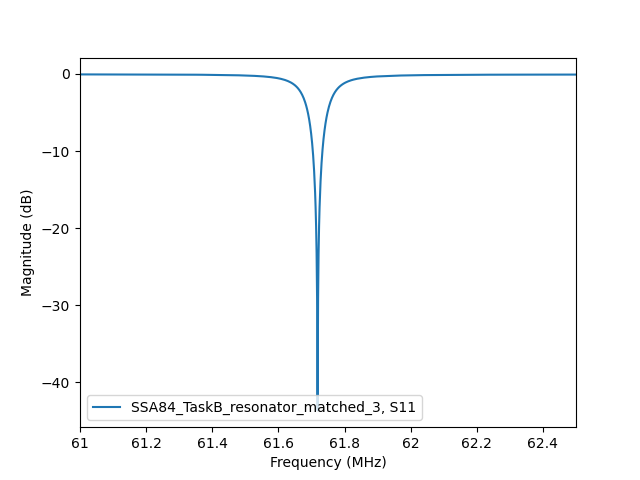

In [2]:
tres_exp = rf.Network('data/SSA84_TaskB_resonator_matched_3.s1p')
#tres_exp = tres_exp.interpolate(rf.Frequency(61.3, 61.8, npoints=1001, unit='MHz'))
tres_exp.frequency.unit = 'MHz'
tres_exp.plot_s_db()

 The match frequency found in practice is:  

In [3]:
# find the match frequency 
exp_freq_match = tres_exp.f[np.argmin(tres_exp.s_mag)]
s11dB_exp = tres_exp.s11.s_db.squeeze()
exp_freq = tres_exp.f # for later use
print(f'Match frequency : {exp_freq_match/1e6} MHz, S11={s11dB_exp.min()} dB')

Match frequency : 61.7185 MHz, S11=-43.62472528568564 dB


## Fitting the measurements to the RF model
We define an optimization function which aims to minimize the error between the measured S11 and the simulated one, for the whole frequency band.

In [4]:
def optim_fun_impedance(short_properties, use_add_loss):
    L_DUT, Z_DUT, L_CEA, Z_CEA, add_loss = short_properties
    # calculates the resonator S11 vs freq
    S11dB = []

    if not use_add_loss: # force no additional loss is requested
        add_loss = 1                        
    _cfg = T.Configuration(exp_freq_match, P_in=1, L_DUT=L_DUT, L_CEA=L_CEA, 
                           Z_short_DUT=Z_DUT, Z_short_CEA=Z_CEA, 
                           additional_losses=add_loss)
    
    s11dB_model = _cfg.circuit(tres_exp.frequency).network['61.4-62MHz'].s_mag.squeeze()
    
    reference = tres_exp['61.4-62MHz'].s_mag.squeeze()  
    model = _cfg.circuit(tres_exp.frequency).network['61.4-62MHz'].s_mag.squeeze()
    # least squares
    crit = sum((reference - model)**2)
    #crit = canberra(reference, model)
    print(short_properties, crit)
    return crit  

Then we launch the minimization process, starting from first guess.

Two minimization are launches: one taking into account a multiplicative loss coefficient, and one without.

<IPython.core.display.Javascript object>


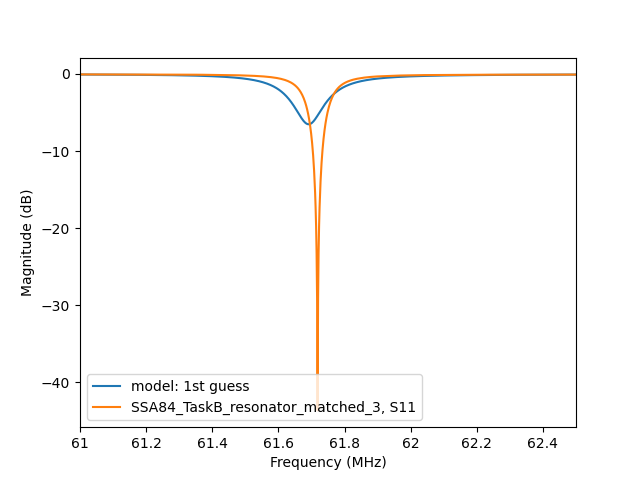

In [5]:
# first guess (SSA84)
L_DUT_0 = 0.023 # m
L_CEA_0 = 0.15 # m
Z_DUT_0 = 0.05 # Ohm
Z_CEA_0 = 0.05 # Ohm
use_add_loss = True # multiplicative coefficient on total RF loss

fig, ax = plt.subplots()
T.Configuration(exp_freq_match, P_in=1, L_DUT=L_DUT_0, L_CEA=L_CEA_0, 
                           Z_short_DUT=Z_DUT_0, Z_short_CEA=Z_CEA_0, 
                           additional_losses=1).circuit(tres_exp.frequency).network.plot_s_db(ax=ax, label='model: 1st guess')
tres_exp.plot_s_db(ax=ax)

In [6]:
# find a optimum taking into account additional losses
bounds_pties = ((5e-3, 100e-3), (1e-6, 1), # L,Z DUT
                (5e-3, 400e-3), (1e-6, 1), # L,Z CEA
                (0.5, 1.5)) # multiplicative constant to the conductivity values
use_add_loss = True
opt_res = minimize(optim_fun_impedance, (L_DUT_0, Z_DUT_0, L_CEA_0, Z_CEA_0, 0.9),
                  bounds=bounds_pties, args=(use_add_loss))
print(opt_res)

[0.023 0.05  0.15  0.05  0.9  ] 6.613851895113542
[0.023 0.05  0.15  0.05  0.9  ] 6.613902913551092
[0.023 0.05  0.15  0.05  0.9  ] 6.613852053343139
[0.023 0.05  0.15  0.05  0.9  ] 6.6138712636728085
[0.023 0.05  0.15  0.05  0.9  ] 6.613852108904821
[0.023 0.05  0.15  0.05  0.9  ] 6.613851897172834
[5.000e-03 1.000e-06 5.000e-03 1.000e-06 6.941e-01] 25.032020182006168
[5.000e-03 1.000e-06 5.000e-03 1.000e-06 6.941e-01] 25.03202019609893
[5.000e-03 1.010e-06 5.000e-03 1.000e-06 6.941e-01] 25.032020540188917
[5.000e-03 1.000e-06 5.000e-03 1.000e-06 6.941e-01] 25.032020178319332
[5.000e-03 1.000e-06 5.000e-03 1.010e-06 6.941e-01] 25.032020189006786
[5.000e-03 1.000e-06 5.000e-03 1.000e-06 6.941e-01] 25.032020132066915
[0.018 0.035 0.106 0.035 0.838] 24.601771645787775
[0.018 0.035 0.106 0.035 0.838] 24.60177165653694
[0.018 0.035 0.106 0.035 0.838] 24.60177164515049
[0.018 0.035 0.106 0.035 0.838] 24.60177146389658
[0.018 0.035 0.106 0.035 0.838] 24.601771570044885
[0.018 0.035 0.106 0.0

[2.490e-02 1.010e-06 1.421e-01 1.217e-02 8.705e-01] 0.773302057795847
[2.490e-02 1.000e-06 1.421e-01 1.217e-02 8.705e-01] 0.773304209569502
[2.490e-02 1.000e-06 1.421e-01 1.217e-02 8.705e-01] 0.773300190135517
[2.490e-02 1.000e-06 1.421e-01 1.217e-02 8.705e-01] 0.7733004678752541
[2.490e-02 1.000e-06 1.421e-01 1.217e-02 8.705e-01] 0.7729834708813987
[2.490e-02 1.000e-06 1.421e-01 1.217e-02 8.705e-01] 0.7729986569963448
[2.490e-02 1.010e-06 1.421e-01 1.217e-02 8.705e-01] 0.7729835690205482
[2.490e-02 1.000e-06 1.421e-01 1.217e-02 8.705e-01] 0.7729871226496785
[2.490e-02 1.000e-06 1.421e-01 1.217e-02 8.705e-01] 0.7729831554564318
[2.490e-02 1.000e-06 1.421e-01 1.217e-02 8.705e-01] 0.7729823374295492
[2.490e-02 1.000e-06 1.421e-01 1.217e-02 8.705e-01] 0.7729187197286159
[2.490e-02 1.000e-06 1.421e-01 1.217e-02 8.705e-01] 0.772933875868879
[2.490e-02 1.010e-06 1.421e-01 1.217e-02 8.705e-01] 0.7729203679648873
[2.490e-02 1.000e-06 1.421e-01 1.217e-02 8.705e-01] 0.7729223607246544
[2.490e-02

[2.258e-02 1.000e-06 1.485e-01 2.287e-02 8.704e-01] 0.05548411457880119
[2.258e-02 1.000e-06 1.485e-01 2.287e-02 8.704e-01] 0.055484120543852176
[2.258e-02 1.000e-06 1.485e-01 2.287e-02 8.704e-01] 0.05548434563669068
[2.259e-02 1.000e-06 1.484e-01 2.306e-02 8.704e-01] 0.05550710006045605
[2.259e-02 1.000e-06 1.484e-01 2.306e-02 8.704e-01] 0.055506996828575426
[2.259e-02 1.010e-06 1.484e-01 2.306e-02 8.704e-01] 0.0555069704320948
[2.259e-02 1.000e-06 1.484e-01 2.306e-02 8.704e-01] 0.05550706495546995
[2.259e-02 1.000e-06 1.484e-01 2.306e-02 8.704e-01] 0.05550710253570933
[2.259e-02 1.000e-06 1.484e-01 2.306e-02 8.704e-01] 0.05550664881626526
[2.258e-02 1.000e-06 1.485e-01 2.295e-02 8.704e-01] 0.05548753354093453
[2.258e-02 1.000e-06 1.485e-01 2.295e-02 8.704e-01] 0.05548748123543548
[2.258e-02 1.010e-06 1.485e-01 2.295e-02 8.704e-01] 0.05548774951598172
[2.258e-02 1.000e-06 1.485e-01 2.295e-02 8.704e-01] 0.055487515475537916
[2.258e-02 1.000e-06 1.485e-01 2.295e-02 8.704e-01] 0.05548753

[2.258e-02 1.008e-06 1.485e-01 2.287e-02 8.704e-01] 0.05548364505134934
[2.258e-02 1.008e-06 1.485e-01 2.287e-02 8.704e-01] 0.05548364610357355
[2.258e-02 1.008e-06 1.485e-01 2.287e-02 8.704e-01] 0.055483770828413465
[2.258e-02 1.000e-06 1.485e-01 2.287e-02 8.704e-01] 0.0554840785290191
[2.258e-02 1.000e-06 1.485e-01 2.287e-02 8.704e-01] 0.055484084761398794
[2.258e-02 1.010e-06 1.485e-01 2.287e-02 8.704e-01] 0.055483656305172054
[2.258e-02 1.000e-06 1.485e-01 2.287e-02 8.704e-01] 0.05548408093604857
[2.258e-02 1.000e-06 1.485e-01 2.287e-02 8.704e-01] 0.05548407856484864
[2.258e-02 1.000e-06 1.485e-01 2.287e-02 8.704e-01] 0.05548408788928405
[2.258e-02 1.007e-06 1.485e-01 2.287e-02 8.704e-01] 0.0554842600489789
[2.258e-02 1.007e-06 1.485e-01 2.287e-02 8.704e-01] 0.05548425831032567
[2.258e-02 1.017e-06 1.485e-01 2.287e-02 8.704e-01] 0.05548426416455813
[2.258e-02 1.007e-06 1.485e-01 2.287e-02 8.704e-01] 0.055484259496113124
[2.258e-02 1.007e-06 1.485e-01 2.287e-02 8.704e-01] 0.05548426

[2.258e-02 1.008e-06 1.485e-01 2.287e-02 8.704e-01] 0.05548393329371819
[2.258e-02 1.008e-06 1.485e-01 2.287e-02 8.704e-01] 0.055483933868009205
[2.258e-02 1.008e-06 1.485e-01 2.287e-02 8.704e-01] 0.055483973415476964
[2.258e-02 1.008e-06 1.485e-01 2.287e-02 8.704e-01] 0.05548373446965831
[2.258e-02 1.008e-06 1.485e-01 2.287e-02 8.704e-01] 0.055483731468140875
[2.258e-02 1.018e-06 1.485e-01 2.287e-02 8.704e-01] 0.0554843485824894
[2.258e-02 1.008e-06 1.485e-01 2.287e-02 8.704e-01] 0.05548373345071068
[2.258e-02 1.008e-06 1.485e-01 2.287e-02 8.704e-01] 0.05548373446558159
[2.258e-02 1.008e-06 1.485e-01 2.287e-02 8.704e-01] 0.05548413125392744
[2.258e-02 1.008e-06 1.485e-01 2.287e-02 8.704e-01] 0.055483638579996726
[2.258e-02 1.008e-06 1.485e-01 2.287e-02 8.704e-01] 0.05548363556527666
[2.258e-02 1.018e-06 1.485e-01 2.287e-02 8.704e-01] 0.05548408028443685
[2.258e-02 1.008e-06 1.485e-01 2.287e-02 8.704e-01] 0.055483637556961354
[2.258e-02 1.008e-06 1.485e-01 2.287e-02 8.704e-01] 0.055483

[2.258e-02 1.008e-06 1.485e-01 2.287e-02 8.704e-01] 0.05548348741088635
[2.258e-02 1.008e-06 1.485e-01 2.287e-02 8.704e-01] 0.055483488428351456
[2.258e-02 1.008e-06 1.485e-01 2.287e-02 8.704e-01] 0.05548384338778746
[2.258e-02 1.008e-06 1.485e-01 2.287e-02 8.704e-01] 0.05548348545506293
[2.258e-02 1.008e-06 1.485e-01 2.287e-02 8.704e-01] 0.05548348245151578
[2.258e-02 1.018e-06 1.485e-01 2.287e-02 8.704e-01] 0.055484200563619836
[2.258e-02 1.008e-06 1.485e-01 2.287e-02 8.704e-01] 0.0554834844354808
[2.258e-02 1.008e-06 1.485e-01 2.287e-02 8.704e-01] 0.05548348545329975
[2.258e-02 1.008e-06 1.485e-01 2.287e-02 8.704e-01] 0.05548384654319648
[2.258e-02 1.008e-06 1.485e-01 2.287e-02 8.704e-01] 0.05548348545506016
[2.258e-02 1.008e-06 1.485e-01 2.287e-02 8.704e-01] 0.05548348245152153
[2.258e-02 1.018e-06 1.485e-01 2.287e-02 8.704e-01] 0.055484200563617116
[2.258e-02 1.008e-06 1.485e-01 2.287e-02 8.704e-01] 0.05548348443547769
[2.258e-02 1.008e-06 1.485e-01 2.287e-02 8.704e-01] 0.05548348

In [7]:
# find a optimum without  additional losses
bounds_pties = ((5e-3, 100e-3), (1e-6, 1), # L,Z DUT
                (5e-3, 400e-3), (1e-6, 1), # L,Z CEA
                (0, 2)) # add losses
use_add_loss = False
opt_res_noloss = minimize(optim_fun_impedance, (L_DUT_0, Z_DUT_0, L_CEA_0, Z_CEA_0, 1.0),
                  bounds=bounds_pties, args=(use_add_loss))
print(opt_res_noloss)

[0.023 0.05  0.15  0.05  1.   ] 6.634555864694838
[0.023 0.05  0.15  0.05  1.   ] 6.634608145855993
[0.023 0.05  0.15  0.05  1.   ] 6.634556001563805
[0.023 0.05  0.15  0.05  1.   ] 6.634575729959964
[0.023 0.05  0.15  0.05  1.   ] 6.634556072378666
[0.023 0.05  0.15  0.05  1.   ] 6.634555864694838
[5.e-03 1.e-06 5.e-03 1.e-06 1.e+00] 25.0508715363761
[5.e-03 1.e-06 5.e-03 1.e-06 1.e+00] 25.050871548133507
[5.00e-03 1.01e-06 5.00e-03 1.00e-06 1.00e+00] 25.050871478031773
[5.e-03 1.e-06 5.e-03 1.e-06 1.e+00] 25.050871533301976
[5.00e-03 1.00e-06 5.00e-03 1.01e-06 1.00e+00] 25.05087142964439
[5.e-03 1.e-06 5.e-03 1.e-06 1.e+00] 25.0508715363761
[0.018 0.035 0.106 0.035 1.   ] 24.62733118999664
[0.018 0.035 0.106 0.035 1.   ] 24.627331201395354
[0.018 0.035 0.106 0.035 1.   ] 24.627331189299525
[0.018 0.035 0.106 0.035 1.   ] 24.62733101788983
[0.018 0.035 0.106 0.035 1.   ] 24.627331114488026
[0.018 0.035 0.106 0.035 1.   ] 24.62733118999664
[0.022 0.046 0.139 0.046 1.   ] 26.49104925222

[0.022 0.003 0.15  0.005 1.   ] 0.33510856827836444
[0.022 0.003 0.15  0.005 1.   ] 0.33510905182420664
[2.282e-02 4.627e-04 1.478e-01 2.541e-02 1.000e+00] 0.05827265880678508
[2.282e-02 4.627e-04 1.478e-01 2.541e-02 1.000e+00] 0.05827416202964398
[2.282e-02 4.627e-04 1.478e-01 2.541e-02 1.000e+00] 0.05827254744129597
[2.282e-02 4.627e-04 1.478e-01 2.541e-02 1.000e+00] 0.05827310307140847
[2.282e-02 4.627e-04 1.478e-01 2.541e-02 1.000e+00] 0.05827264438689177
[2.282e-02 4.627e-04 1.478e-01 2.541e-02 1.000e+00] 0.05827265880678508
[2.271e-02 7.431e-04 1.481e-01 2.449e-02 1.000e+00] 0.054296250739187264
[2.271e-02 7.431e-04 1.481e-01 2.449e-02 1.000e+00] 0.054297662380896304
[2.271e-02 7.431e-04 1.481e-01 2.449e-02 1.000e+00] 0.054296156575987686
[2.271e-02 7.431e-04 1.481e-01 2.449e-02 1.000e+00] 0.05429670009969311
[2.271e-02 7.431e-04 1.481e-01 2.449e-02 1.000e+00] 0.05429624292722783
[2.271e-02 7.431e-04 1.481e-01 2.449e-02 1.000e+00] 0.054296250739187264
[0.022 0.002 0.149 0.019 1. 

[2.271e-02 1.186e-02 1.482e-01 1.000e-06 1.000e+00] 0.0068047061300342245
[2.271e-02 1.186e-02 1.482e-01 1.000e-06 1.000e+00] 0.006804925711510175
[2.271e-02 1.186e-02 1.482e-01 1.000e-06 1.000e+00] 0.00680470207924984
[2.271e-02 1.186e-02 1.482e-01 1.000e-06 1.000e+00] 0.0068047898102807
[2.271e-02 1.186e-02 1.482e-01 1.010e-06 1.000e+00] 0.006804726873164204
[2.271e-02 1.186e-02 1.482e-01 1.000e-06 1.000e+00] 0.0068047061300342245
[2.280e-02 1.215e-02 1.479e-01 1.000e-06 1.000e+00] 0.00669505501338952
[2.280e-02 1.215e-02 1.479e-01 1.000e-06 1.000e+00] 0.006694407710016947
[2.280e-02 1.215e-02 1.479e-01 1.000e-06 1.000e+00] 0.006695048654125145
[2.280e-02 1.215e-02 1.479e-01 1.000e-06 1.000e+00] 0.006694822759940284
[2.280e-02 1.215e-02 1.479e-01 1.010e-06 1.000e+00] 0.006695061797749806
[2.280e-02 1.215e-02 1.479e-01 1.000e-06 1.000e+00] 0.00669505501338952
[2.286e-02 1.243e-02 1.478e-01 1.000e-06 1.000e+00] 0.0064547616321694486
[2.286e-02 1.243e-02 1.478e-01 1.000e-06 1.000e+00] 0

Now the results:

In [8]:
print(f'SSA84 - With losses: \t\t L_DUT_0={opt_res.x[0]:.4}, Z_DUT_0={opt_res.x[1]:.4}',
        f' L_CEA_0={opt_res.x[2]:.4}, Z_CEA_0={opt_res.x[3]:.4}, add_loss={opt_res.x[4]:.4}')

print(f'SSA84 - Without losses: \t L_DUT_0={opt_res_noloss.x[0]:.4}, Z_DUT_0={opt_res_noloss.x[1]:.4},', 
      f'L_CEA_0={opt_res_noloss.x[2]:.4}, Z_CEA_0={opt_res_noloss.x[3]:.4}, add_loss={opt_res_noloss.x[4]:.4}')


SSA84 - With losses: 		 L_DUT_0=0.02258, Z_DUT_0=1.008e-06  L_CEA_0=0.1485, Z_CEA_0=0.02287, add_loss=0.8704
SSA84 - Without losses: 	 L_DUT_0=0.02291, Z_DUT_0=0.01273, L_CEA_0=0.1476, Z_CEA_0=1e-06, add_loss=1.0


Graphically:

<IPython.core.display.Javascript object>


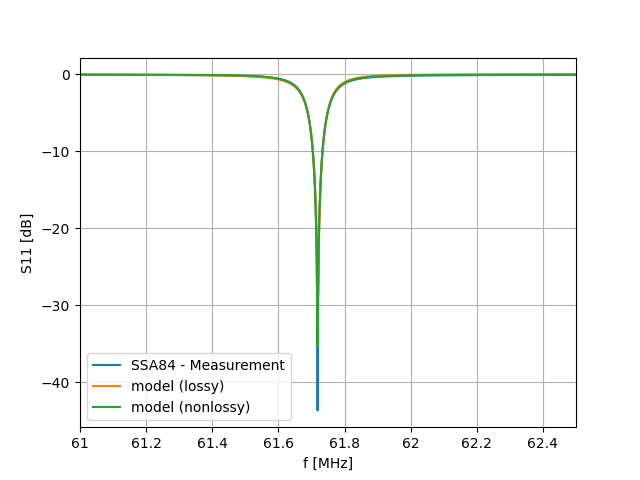

Text(0, 0.5, 'S11 [dB]')

In [10]:
P_in = 20e3 # W

S11dB = []
S11dB_noloss = []

L_DUT_opt, Z_DUT_opt, L_CEA_opt, Z_CEA_opt, add_loss_opt = opt_res.x
cfg_lossy = T.Configuration(61.71e3, P_in, L_DUT_opt, L_CEA_opt, 
                           Z_short_DUT = Z_DUT_opt, Z_short_CEA = Z_CEA_opt, 
                           additional_losses=add_loss_opt)

L_DUT_opt_nl, Z_DUT_opt_nl, L_CEA_opt_nl, Z_CEA_opt_nl, add_loss_opt_nl = opt_res_noloss.x
cfg_nonlossy = T.Configuration(61.71e3, P_in, L_DUT_opt_nl, L_CEA_opt_nl, 
                           Z_short_DUT = Z_DUT_opt_nl, Z_short_CEA = Z_CEA_opt_nl, 
                           additional_losses=add_loss_opt_nl)
   

fig,ax=plt.subplots()
tres_exp.plot_s_db(ax=ax, color='C0', label='SSA84 - Measurement')
cfg_lossy.circuit(tres_exp.frequency).network.plot_s_db(ax=ax, color='C1', label='model (lossy)')
cfg_nonlossy.circuit(tres_exp.frequency).network.plot_s_db(ax=ax, color='C2', label='model (nonlossy)')
plt.grid(True)
ax.set_xlabel('f [MHz]')
ax.set_ylabel('S11 [dB]')


## Quality Factor

Calculating the Quality factor Q as:
$$
Q = \frac{f_0}{\Delta f}
$$
where $\Delta f$ is the 3 dB bandwidth and $f_0$ the resonating frequency.

In [14]:
s_dB = tres_exp.s11.s_db
S11_max = s_dB.max()
S11_min_idx = rf.find_nearest_index(s_dB, s_dB.min())
print(f'Resonance frequency f0={exp_freq[S11_min_idx]/1e6} MHz')

S11_Deltaf_low_idx = rf.find_nearest_index(s_dB[:S11_min_idx], S11_max - 3)
S11_Deltaf_upp_idx = rf.find_nearest_index(s_dB[S11_min_idx:], S11_max - 3) + S11_min_idx
print(f'-3 dB frequencies: f1={exp_freq[S11_Deltaf_low_idx]/1e6} MHz and f2={exp_freq[S11_Deltaf_upp_idx]/1e6} MHz, ')

Deltaf = exp_freq[S11_Deltaf_upp_idx] - exp_freq[S11_Deltaf_low_idx]
print(f'Delta_f = f2 - f1 = {Deltaf/1e6} MHz')

Q = exp_freq[S11_min_idx] / Deltaf
print(f'Q={Q}')

Resonance frequency f0=61.7185 MHz
-3 dB frequencies: f1=61.675 MHz and f2=61.762 MHz, 
Delta_f = f2 - f1 = 0.087 MHz
Q=709.4080459770115
